In [1]:
import os
import numpy as np
from scipy.stats import pearsonr
import pandas as pd


# plotting modules
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 5, 'ytick.major.width': 1.5, 'ytick.major.size': 4})
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import ConnectionPatch

/data5/deepro/miniconda3/envs/starrseq/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight', dpi=300)
    pdf.close()
    return

In [3]:
save_dir = "/data5/deepro/starrseq/papers/results/6_link_da_enhancers_to_de_genes/data/da_enhancers_to_de_genes_links"
tgi_dir = "/data5/deepro/starrseq/papers/results/6_link_da_enhancers_to_de_genes/data/targets"

In [4]:
libs = ["ATF2", "CTCF", "FOXA1", "LEF1", "SCRT1", "TCF7L2", "16P12_1"]

libs_chrom_list = {
    "ATF2": {
        "induced": ["chr22_39524170_39524670", "chr15_67150328_67150821"],
        "repressed": ["chr16_3841737_3842237", "chr19_33380587_33381087"],
        "lost": ["chr1_212596184_212596684"],
        "gained": ["chrX_46710284_46710784", "chr14_73228279_73228779"]
    },
    "CTCF": {},
    "FOXA1": {},
    "LEF1": {},
    "SCRT1": {},
    "TCF7L2": {},
    "16P12_1": {
        "gained": ["chr9_73132313_73132813"], 
        "lost": ["chr1_228490086_228490586"],
        "induced":["chr21_26798607_26799107"],
        "repressed":["chr16_578465_578965", "chr9_14352445_14352945"]
        }
}

In [5]:
def get_tgi_df(filedir, lib):
    filename = os.path.join(filedir, f"{lib}.tsv")
    return filename

def get_known_linked_targets(target_df, known_targets, lib):
    target_df = target_df.loc[target_df.gene_name.isin(known_targets)].sort_values([f"{lib}_padj", "neglog10padj"])
    # agree directions
    target_df = target_df.loc[np.sign(target_df[f"{lib}_log2FoldChange"]) == np.sign(target_df["log2FoldChange"])]
    # filter gene log fc
    target_df = target_df.loc[(target_df["log2FoldChange"]>0.75)|(target_df["log2FoldChange"]<-0.75)]
    # sort by neglog10padj and then by log2FC of the gene
    target_df["abs_log2FoldChange"] = abs(target_df["log2FoldChange"])
    target_df = target_df.sort_values(["neglog10padj", "abs_log2FoldChange"], ascending=False).drop(
        columns=["abs_log2FoldChange"]
        )
    return target_df

def get_top_targets(ftype_df, tgi_dir, lib):
    # get tf link target genes for lib
    tgi_file = get_tgi_df(tgi_dir, lib)
    tgi_df = pd.read_csv(tgi_file, sep="\t")
    all_targets = tgi_df["Name.Target"].values
    # get known targets' da enhancers
    target_df = get_known_linked_targets(ftype_df, all_targets, lib)
    return target_df

def load_fragments(save_dir, lib):
    fragment_types = ["unresponsive", "induced", "repressed", "gained", "lost"]
    fragment_type_dfs = []
    for fragment_type in fragment_types:
        fragment_type_file = os.path.join(save_dir, lib, f"{fragment_type}.csv")
        if os.path.exists(fragment_type_file):
            fragment_df = pd.read_csv(fragment_type_file)
        else:
            fragment_df = pd.DataFrame(columns=fragment_type_dfs[0].columns)
        fragment_type_dfs.append(fragment_df)
    return dict(zip(fragment_types, fragment_type_dfs))

def load_fragments_with_exp(save_dir, lib):
    fragment_types = ["unresponsive", "induced", "repressed", "gained", "lost"]
    fragment_type_dfs = []
    for fragment_type in ["unresponsive", "induced", "repressed", "gained", "lost"]:
        fragment_type_file = os.path.join(save_dir, lib, f"{fragment_type}_merged.csv")
        if os.path.exists(fragment_type_file):
            fragment_df = pd.read_csv(fragment_type_file)
            fragment_df = set_upper_limit_padj(fragment_df)
        else:
            fragment_df = pd.DataFrame(columns=fragment_type_dfs[0].columns)
        fragment_type_dfs.append(fragment_df)
    return dict(zip(fragment_types, fragment_type_dfs))

def set_upper_limit_padj(df):
    df.loc[df.neglog10padj>25, "neglog10padj"] = 25
    return df

def load_volcano(save_dir, lib):
    volcano_file = os.path.join(save_dir, lib, "volcano.csv")
    volcano_df = pd.read_csv(volcano_file)
    volcano_df = set_upper_limit_padj(volcano_df)
    return volcano_df

In [6]:
def plot_links(save_dir, lib, chrom_list=dict(), tgi_dir="./"):

    fragment_dict = load_fragments(save_dir, lib)
    fragment_with_exp_dict = load_fragments_with_exp(save_dir, lib)
    volcano_df = load_volcano(save_dir, lib)

    xval_col = f"{lib}_log2FoldChange"
    # define canvas
    fig, axes = plt.subplots(1, 2, figsize=(12,6))

    # Enhancers
    sf=4
    sns.scatterplot(data=fragment_dict["unresponsive"], y="CC", x=xval_col, s=1*sf, alpha=0.2, color="grey", ax=axes[0], rasterized=True)
    sns.scatterplot(data=fragment_dict["induced"], y="CC", x=xval_col, s=2*sf, alpha=0.25, color="green", ax=axes[0], rasterized=True)
    sns.scatterplot(data=fragment_dict["repressed"], y="CC", x=xval_col, s=2*sf, alpha=0.25, color="red", ax=axes[0], rasterized=True)
    sns.scatterplot(data=fragment_dict["gained"], y="CC", x=xval_col, s=2*sf, alpha=0.5, color="navy", ax=axes[0], rasterized=True)
    sns.scatterplot(data=fragment_dict["lost"], y="CC", x=xval_col, s=2*sf, alpha=0.5, color="k", ax=axes[0], rasterized=True)

    axes[0].axhline(0, color="k", ls=":")
    axes[0].axvline(0.25, color="k", ls="--")
    axes[0].axvline(-0.25, color="k", ls="--")
    axes[0].spines[['top']].set_visible(False)
    axes[0].spines[['right']].set_linestyle((0, (3, 10, 1, 10, 1, 10)))
    axes[0].set_xlabel("Enhancer Response")
    axes[0].set_ylabel("Activity in control")

    # Genes
    sns.scatterplot(
        data=volcano_df, x="log2FoldChange", y="neglog10padj", 
        hue="hue", palette={"Significant Down": "red", "Not Significant": "grey", "Significant Up": "green"},
        size="hue", sizes={"Significant Up": 7.5, "Not Significant":1, "Significant Down": 7.5}, 
        ax=axes[1], alpha=0.5, rasterized=True, legend=False,
        )
    axes[1].axvline(x=0.5, linestyle="--", color="k")
    axes[1].axvline(x=-0.5, linestyle="--", color="k")
    axes[1].axhline(y=-np.log10(0.01), linestyle=":", color="k")
    axes[1].yaxis.tick_right()
    axes[1].spines[['top']].set_visible(False)
    axes[1].spines[['left']].set_linestyle((0, (3, 10, 1, 10, 1, 10)))
    axes[1].yaxis.set_label_position("right")
    axes[1].set_xlabel("Gene Response")


    # add Enhancer to Gene targets
    if chrom_list:
        for fragment_type in chrom_list.keys():
            fragment_df = fragment_with_exp_dict[fragment_type]
            locs = chrom_list[fragment_type]
            if len(fragment_df)>0:
                tg_df = fragment_df.loc[fragment_df.chrom_coord.isin(locs)]
                for xa, ya, xb, yb, loc, gn in zip(tg_df[xval_col], tg_df["CC"], tg_df["log2FoldChange"], tg_df["neglog10padj"], tg_df["chrom_coord"], tg_df["gene_name"]):
                    axes[0].annotate(loc, (xa, ya), fontsize=10, ha="center")
                    axes[1].annotate(gn, (xb, yb), fontsize=10, ha="center")
                    connectstyle = "arc3,rad=-0.5"
                    if fragment_type in ["gained", "induced"]:
                        connectstyle = "arc3,rad=0.5"
                    con = ConnectionPatch(
                        xyA=(xa, ya), coordsA=axes[0].transData,
                        xyB=(xb, yb), coordsB=axes[1].transData,
                        arrowstyle="<->", connectionstyle=connectstyle, label=f'{loc} :: {gn}')
                    fig.add_artist(con)
    else:
        for fragment_type in ["gained", "lost", "induced", "repressed"]:
            fragment_df = fragment_with_exp_dict[fragment_type]
            tg_df = get_top_targets(fragment_df, tgi_dir, lib)
            if len(fragment_df)>0:
                tg_df_save_file = os.path.join(save_dir, lib, f"{fragment_type}_known.csv")
                tg_df.to_csv(tg_df_save_file, index=False)
                tg_df = tg_df.head(2)
                for xa, ya, xb, yb, loc, gn in zip(tg_df[xval_col], tg_df["CC"], tg_df["log2FoldChange"], tg_df["neglog10padj"], tg_df["chrom_coord"], tg_df["gene_name"]):
                    axes[0].annotate(loc, (xa, ya), fontsize=10, ha="center")
                    axes[1].annotate(gn, (xb, yb), fontsize=10, ha="center")
                    connectstyle = "arc3,rad=-0.5"
                    if fragment_type in ["gained", "induced"]:
                        connectstyle = "arc3,rad=0.5"
                    con = ConnectionPatch(
                        xyA=(xa, ya), coordsA=axes[0].transData,
                        xyB=(xb, yb), coordsB=axes[1].transData,
                        arrowstyle="<->", connectionstyle=connectstyle, label=f'{loc} :: {gn}')
                    fig.add_artist(con)


    save_dir = os.path.join(save_dir, lib)
    os.makedirs(save_dir, exist_ok=True)
    save_file = os.path.join(save_dir, f"da_de_links.pdf")
    save_pdf(save_file, fig)
    return


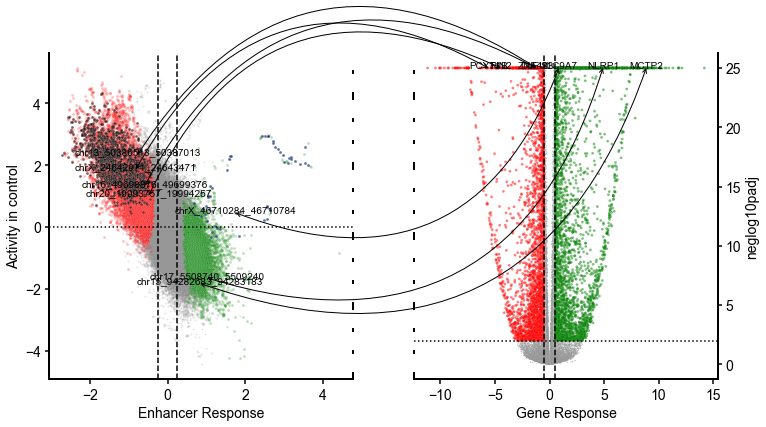

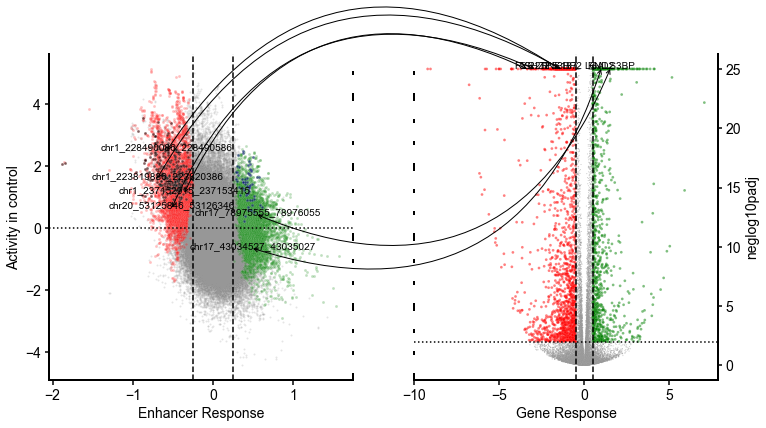

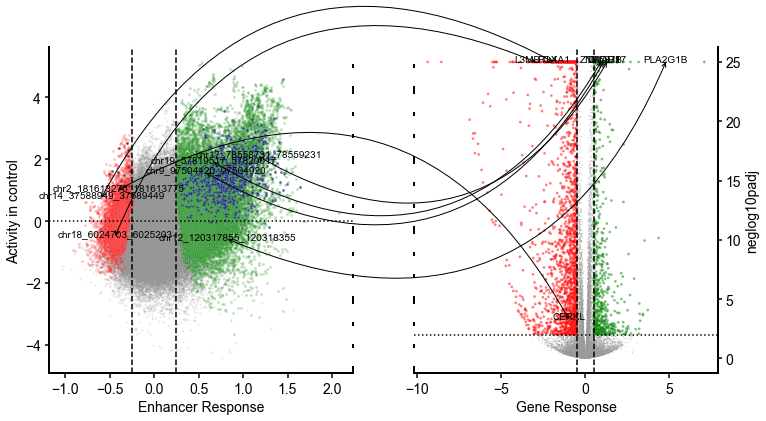

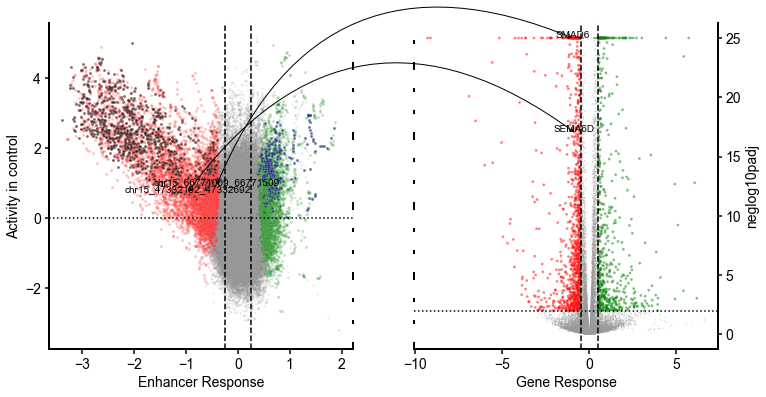

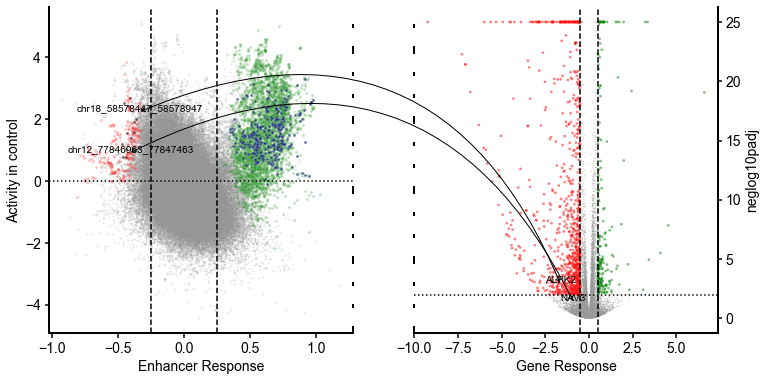

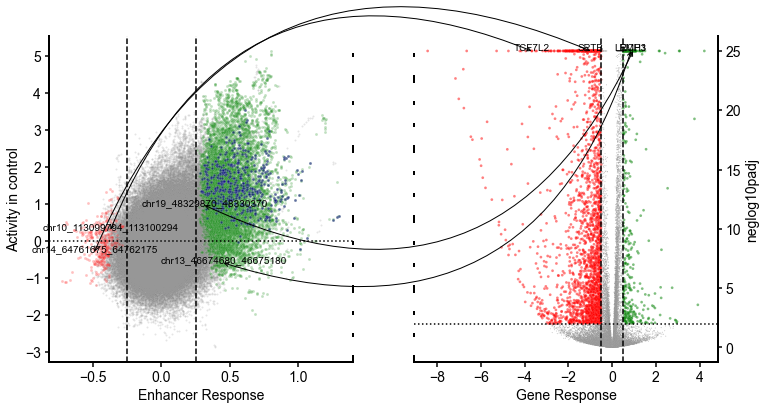

In [7]:
for lib in libs[:-1]:
    lib_chrom_list = libs_chrom_list[lib]
    plot_links(save_dir, lib, tgi_dir=tgi_dir)

# 16P12_1

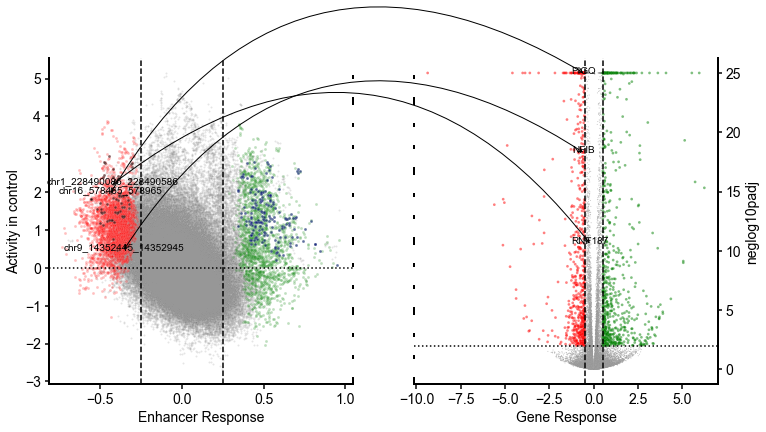

In [8]:
plot_links(save_dir, "16P12_1", chrom_list=libs_chrom_list["16P12_1"])